In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

/home/maslinux/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train = train[["MSSubClass", 
"MSZoning", 
"LotFrontage", 
"LotArea", 
"Street", 
"LotShape", 
"LandContour", 
"Utilities", 
"LotConfig", 
"Neighborhood", 
"Condition1", 
"Condition2", 
"HouseStyle", 
"OverallQual", 
"OverallCond", 
"YearBuilt", 
"ExterQual", 
"BsmtQual", 
"HeatingQC", 
"FullBath", 
"HalfBath", 
"BedroomAbvGr", 
"KitchenQual", 
"TotRmsAbvGrd", 
"FireplaceQu", 
"GarageCars", 
"GarageQual", 
"PoolArea", 
"PoolQC", 
"MoSold", 
"YrSold", 
"SalePrice"]].copy()

In [4]:
test = test[["MSSubClass", 
"MSZoning", 
"LotFrontage", 
"LotArea", 
"Street", 
"LotShape", 
"LandContour", 
"Utilities", 
"LotConfig", 
"Neighborhood", 
"Condition1", 
"Condition2", 
"HouseStyle", 
"OverallQual", 
"OverallCond", 
"YearBuilt", 
"ExterQual", 
"BsmtQual", 
"HeatingQC", 
"FullBath", 
"HalfBath", 
"BedroomAbvGr", 
"KitchenQual", 
"TotRmsAbvGrd", 
"FireplaceQu", 
"GarageCars", 
"GarageQual", 
"PoolArea", 
"PoolQC", 
"MoSold", 
"YrSold"]].copy()

In [5]:
def data_preprocessing_pipeline(train,test,outliers,columns_to_drop,dependent_variable,skew_threshold):
    """Removes outliers, checks for skewness, drops less significant columns
        Works for Regression. It returns X_train, X_test and y
        
    Parameters:
    -----------
    train: A data frame of the training set.

    test: A data frame of the test set.

    outliers: A list of row indices of outliers.

    columns_to_drop: A list columns to drop.
    
    dependent_variable: Specify dependent variable
    
    skew_threshold: Threshold for the skew value
  
    """
    # Drop outliers
    train.drop(train.index[outliers],inplace=True)
    
    train_without_dependent = train.copy()
    train_without_dependent = train_without_dependent.drop(dependent_variable,axis=1)
    
    #train_without_dependent = train.drop(dependent_variable,axis=1,inplace=True)
    combined = pd.concat((train_without_dependent.loc[:],test.loc[:]))
        
    combined = combined.drop(columns_to_drop,axis=1)
    
    train[dependent_variable] = np.log1p(train[dependent_variable])
        
    feats = combined.dtypes[combined.dtypes != "object"].index
    skew_features = train[feats].apply(lambda x: skew(x.dropna()))
    skew_features = skew_features[skew_features > skew_threshold]
    skew_features = skew_features.index
        
    combined[skew_features] = np.log1p(combined[skew_features])
    combined = pd.get_dummies(combined)
    combined = combined.fillna(combined.mean())
        
    X_train = combined[:train.shape[0]]
    X_test = combined[train.shape[0]:]
    y = train[dependent_variable]
        
    return X_train,X_test,y

In [6]:
outliers = [4,11,13,20,46,66,70,167,178,185,199, 224,261, 
           309,313,318, 349,412,423,440,454,477,478, 523,
           540, 581,588,595,654,688, 691, 774, 798, 875, 
           898,926,970,987,1027,1109, 1169,1182,1239, 1256,
           1298,1324,1353,1359,1405,1442,1447]
columns_to_drop = ['FireplaceQu','PoolQC']
skew_threshold = 0.75
dependent_variable = "SalePrice"

In [7]:
Xtrain,Xtest,ytrain = data_preprocessing_pipeline(train,test,outliers,columns_to_drop,dependent_variable,skew_threshold)

In [8]:
# Perform the train / test split
X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=0)

In [9]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,...,HeatingQC_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA
1069,3.828641,4.110874,9.169623,5,7,1949,1,0,2,4,...,1,0,0,1,0,0,0,0,0,1
1028,3.931826,4.382027,9.158310,5,5,1941,1,0,3,6,...,1,0,0,0,1,0,0,0,0,1
466,3.044522,4.454347,9.271341,7,5,1970,1,0,2,5,...,1,0,0,0,1,0,0,0,0,1
1036,3.044522,4.499810,9.464905,9,5,2007,2,0,2,6,...,0,1,0,0,0,0,0,0,0,1
1383,3.433987,4.190382,10.140139,5,7,1918,2,0,3,7,...,0,0,0,1,0,0,0,0,0,1


In [10]:
Xtrain = X_train.join(y_train)

In [11]:
Xtrain.head().T

,1069,1028,466,1036,1383
MSSubClass,3.828641,3.931826,3.044522,3.044522,3.433987
LotFrontage,4.110874,4.382027,4.454347,4.499810,4.190382
LotArea,9.169623,9.158310,9.271341,9.464905,10.140139
OverallQual,5.000000,5.000000,7.000000,9.000000,5.000000
OverallCond,7.000000,5.000000,5.000000,5.000000,7.000000
YearBuilt,1949.000000,1941.000000,1970.000000,2007.000000,1918.000000
FullBath,1.000000,1.000000,1.000000,2.000000,2.000000
HalfBath,0.000000,0.000000,0.000000,0.000000,0.000000
BedroomAbvGr,2.000000,3.000000,2.000000,2.000000,3.000000
TotRmsAbvGrd,4.000000,6.000000,5.000000,6.000000,7.000000


In [25]:
#df1 = df[['a','b']]
df =  Xtrain[["SalePrice", "LotFrontage"]]
#df.columns = ['x', 'y']

In [26]:
df.head()

,SalePrice,LotFrontage
1069,11.813037,4.110874
1028,11.561725,4.382027
466,12.025755,4.454347
1036,12.661917,4.499810
1383,11.626263,4.190382


In [14]:
from sklearn.preprocessing import StandardScaler
x, y = StandardScaler().fit_transform(df[['x', 'y']]).T

In [15]:
import pymc3 as pm
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)

    y_est = a*x + b
    y_obs = pm.Normal('y_obs', mu=y_est, sd=sigma, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(niter, step, start, random_seed=123)

logp = -1,677.9, ||grad|| = 882.68: 100%|██████████| 10/10 [00:00<00:00, 140.93it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:13<00:00, 1534.18draws/s]


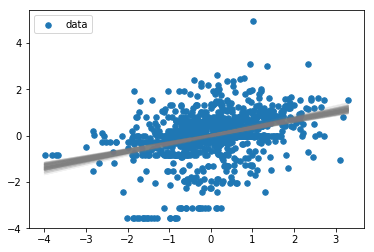

In [16]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

In [17]:
niter = 10000
with pm.Model() as robust_linreg:
    beta = pm.Normal('beta', 0, 10, shape=2)
    nu = pm.Exponential('nu', 1/len(x))
    sigma = pm.HalfCauchy('sigma', beta=1)

    y_est = beta[0] + beta[1]*x
    y_obs = pm.StudentT('y_obs', mu=y_est, sd=sigma, nu=nu, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(niter, step, start, random_seed=123)

logp = -1,390.8, ||grad|| = 61.838: 100%|██████████| 38/38 [00:00<00:00, 1093.13it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, nu, beta]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:23<00:00, 876.72draws/s]


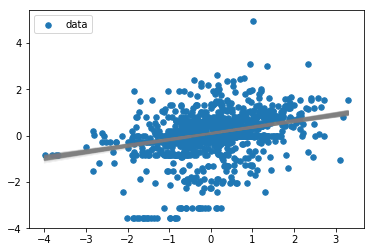

In [18]:
t = trace[niter//2:]
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['beta'][-100:, 1], t['beta'][-100:, 0]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.legend(loc='upper left')
pass

Logistic regression to see the effect of strongly correlated variables.

In [27]:

df2 = Xtrain[["SalePrice","OverallQual","GarageCars"]]
df2.columns = ['a', 'b','c']

In [28]:
df2.head()

,a,b,c
1069,11.813037,5,2.0
1028,11.561725,5,1.0
466,12.025755,7,2.0
1036,12.661917,9,3.0
1383,11.626263,5,2.0


In [29]:
from pymc3.glm import families


In [30]:
pm.glm.GLM

pymc3.glm.linear.GLM

In [ ]:
from pymc3.glm import families
niter = 10000
with pm.Model() as model:
    pm.glm.GLM.from_formula('a ~ b + c', df2, family=pm.glm.families.Binomial())
    start = pm.find_MAP()
    step = pm.Slice()
    trace = pm.sample(niter, start=start, step=step, njobs=4, random_seed=123)

logp = -inf, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 295.74it/s]
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [c]
>Slice: [b]
>Slice: [Intercept]
Sampling 4 chains:   0%|          | 0/42000 [00:00<?, ?draws/s]

In [ ]:
# pm.glm.glm